# XYZ Sports Club - Customer Segmentation

Carlos Eduardo Rodrigues da Costa - 20230543

In [165]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

# Exploratory Data Analysis

In [166]:
df = pd.read_csv('XYZ_sports_dataset.csv', sep=";")
df.head()

,ID,Age,Gender,Income,EnrollmentStart,EnrollmentFinish,LastPeriodStart,LastPeriodFinish,DateLastVisit,DaysWithoutFrequency,...,OtherActivities,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisitsBySLA,AllowedNumberOfVisitsBySLA,RealNumberOfVisits,NumberOfRenewals,HasReferences,NumberOfReferences,Dropout
0,10000,60,Female,5500.0,2019-09-03,2019-10-31,2019-07-01,2019-12-31,2019-10-30,1,...,0.0,9.0,7,NaN,6.28,2,0,0.0,0,0
1,10001,29,Female,2630.0,2014-08-12,2015-09-14,2015-01-01,2015-12-31,2015-07-16,60,...,0.0,23.0,1,2.0,17.42,1,2,0.0,0,1
2,10002,23,Male,1980.0,2017-05-02,2017-06-01,2017-01-01,2017-06-30,2017-05-25,7,...,0.0,6.0,0,7.0,30.03,6,0,0.0,0,1
3,10003,9,Male,0.0,2018-09-05,2019-02-12,2018-07-01,2019-06-30,2019-01-21,22,...,0.0,20.0,2,2.0,17.72,3,0,0.0,0,1
4,10004,35,Male,4320.0,2016-04-20,2018-06-07,2018-01-01,2018-06-30,2017-11-09,210,...,NaN,41.0,0,7.0,60.97,0,3,0.0,0,1


In [167]:
df.shape

(14942, 31)

## Handling Duplicates

In [168]:
df.duplicated().sum()

0

In [169]:
df.drop_duplicates(inplace=True)

## Fixing column types

In [170]:
df.dtypes

ID                              int64
Age                             int64
Gender                         object
Income                        float64
EnrollmentStart                object
EnrollmentFinish               object
LastPeriodStart                object
LastPeriodFinish               object
DateLastVisit                  object
DaysWithoutFrequency            int64
LifetimeValue                 float64
UseByTime                       int64
AthleticsActivities           float64
WaterActivities               float64
FitnessActivities             float64
DanceActivities               float64
TeamActivities                float64
RacketActivities              float64
CombatActivities              float64
NatureActivities              float64
SpecialActivities             float64
OtherActivities               float64
NumberOfFrequencies           float64
AttendedClasses                 int64
AllowedWeeklyVisitsBySLA      float64
AllowedNumberOfVisitsBySLA    float64
RealNumberOf

We can see that the date columns are being represented as "object", so we need to fix it.

In [171]:
df["EnrollmentStart"] = pd.to_datetime(df["EnrollmentStart"])
df["EnrollmentFinish"] = pd.to_datetime(df["EnrollmentFinish"])
df["LastPeriodStart"] = pd.to_datetime(df["LastPeriodStart"])
df["LastPeriodFinish"] = pd.to_datetime(df["LastPeriodFinish"])
df["DateLastVisit"] = pd.to_datetime(df["DateLastVisit"])

DateLastVisit looks like other columns in the dataset.
We'll check the correlation between them to see if we can drop it.

In [172]:
df[["EnrollmentFinish", "LastPeriodFinish", "DateLastVisit"]].corr()

,EnrollmentFinish,LastPeriodFinish,DateLastVisit
EnrollmentFinish,1.000000,0.770579,0.750199
LastPeriodFinish,0.770579,1.000000,0.982803
DateLastVisit,0.750199,0.982803,1.000000


In the end the DateLastVisit is highly correlated with the LastPeriodFinish, so we'll drop it.

In [173]:
df.drop("DateLastVisit", axis=1, inplace=True)

Now we can do some feature engineering to create new columns that represent the duration of enrollment and last period
in order to reduce dimensionality.

In [174]:
df["EnrollmentDurationInDays"] = (df["EnrollmentFinish"] - df["EnrollmentStart"]).dt.days
df["LastPeriodDurationInDays"] = (df["LastPeriodFinish"] - df["LastPeriodStart"]).dt.days

df.drop(["EnrollmentStart", "EnrollmentFinish", "LastPeriodStart", "LastPeriodFinish"], axis=1, inplace=True)

The gender column is also being represented as "object" and should be categorical.

In [175]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == "Male" else 0)

We can see that the columns "DanceActivities" and "NatureActivities" only have zeroes.
As they fall into activities that are not used by any custom, we'll drop them.

Also, the ID column is not useful for our analysis, so we'll drop it too.

Lastly, we'll drop both "HasReferences" and "NumberOfReferences" columns as almost all customers (~98%) don't have any references.

In [176]:
df["HasReferences"].value_counts() / df.shape[0] * 100

HasReferences
0.0    97.932004
1.0     1.987686
Name: count, dtype: float64

In [177]:
columns_to_drop = [
    'DanceActivities',
    'NatureActivities',
    'ID',
    'HasReferences',
    'NumberOfReferences'
]
df.drop(columns_to_drop, axis=1, inplace=True)

In [178]:
categorical_features = [
    "Gender",
    "UseByTime",
    "AthleticsActivities",
    "WaterActivities",
    "FitnessActivities",
    "TeamActivities",
    "RacketActivities",
    "CombatActivities",
    "SpecialActivities",
    "OtherActivities",
    "Dropout"
]

numeric_features = [
    "Age",
    "Income",
    "EnrollmentDurationInDays",
    "LastPeriodDurationInDays",
    "DaysWithoutFrequency",
    "LifetimeValue",
    "NumberOfFrequencies",
    "AttendedClasses",
    "AllowedWeeklyVisitsBySLA",
    "AllowedNumberOfVisitsBySLA",
    "RealNumberOfVisits",
    "NumberOfRenewals"
]

## Handling missing values
TODO

In [179]:
df.isna().sum() / df.shape[0] * 100 

Age                           0.000000
Gender                        0.000000
Income                        3.312810
DaysWithoutFrequency          0.000000
LifetimeValue                 0.000000
UseByTime                     0.000000
AthleticsActivities           0.240932
WaterActivities               0.247624
FitnessActivities             0.234239
TeamActivities                0.234239
RacketActivities              0.247624
CombatActivities              0.220854
SpecialActivities             0.294472
OtherActivities               0.234239
NumberOfFrequencies           0.174006
AttendedClasses               0.000000
AllowedWeeklyVisitsBySLA      3.580511
AllowedNumberOfVisitsBySLA    0.000000
RealNumberOfVisits            0.000000
NumberOfRenewals              0.000000
NumberOfReferences            0.000000
Dropout                       0.000000
EnrollmentDurationInDays      0.000000
LastPeriodDurationInDays      0.000000
dtype: float64

Among continuous variables, only the `Income`, `AllowedWeeklyVisitsBySLA` and `NumberOfFrequencies` columns contain missing values.
We'll drop the rows with missing values.
<span color="red">TODO: AFTER FIRST ITERATION OF CLUSTERING, CHECK HOW INPUTING WILL CHANGE THE SHAPE OF CLUSTERS</span>

In [180]:
df.dropna(inplace=True)

# Outlier detection
TODO

In [181]:
profile = ProfileReport(
    df[numeric_features],
    title='XYZ Sports Club - Customer Segmentation',
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": False},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False},
        "cramers": {"calculate": False},
    },
)
# profile.to_notebook_iframe())

## Checking numeric features correlations

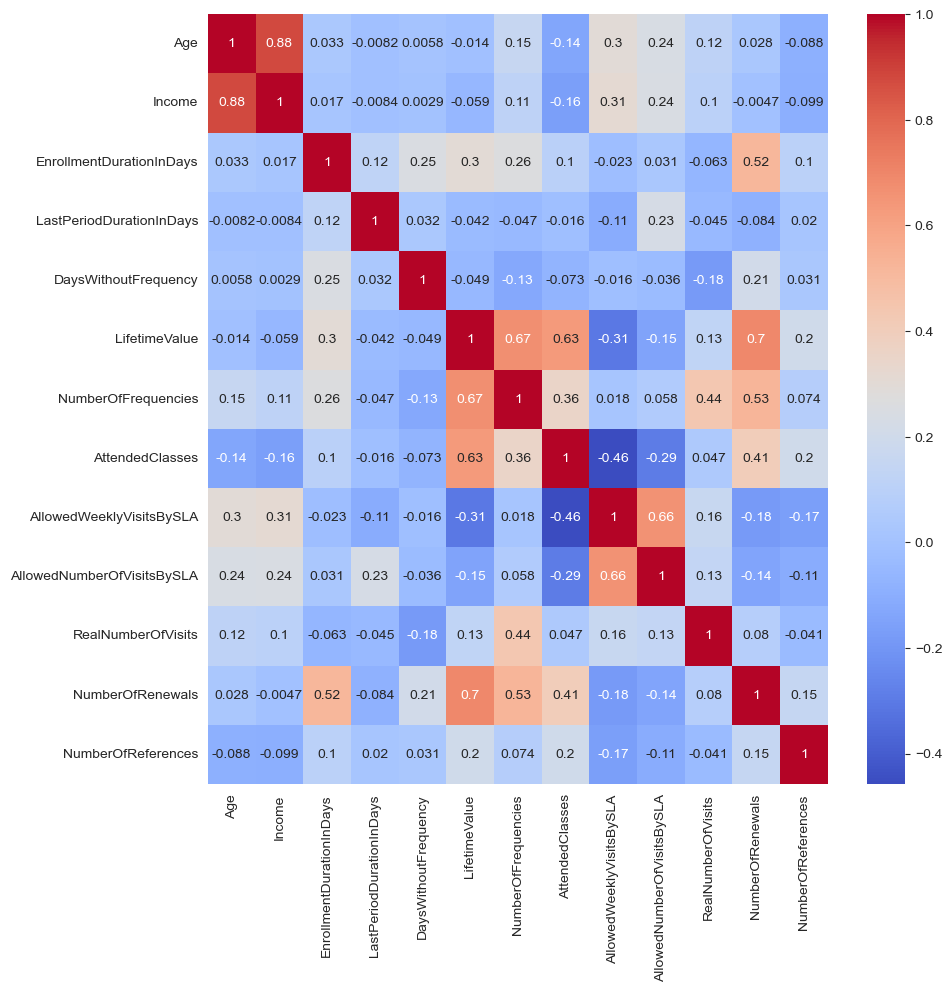

In [182]:
%matplotlib inline
corr = df[numeric_features].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [183]:
df.drop('Age', axis=1, inplace=True)
numeric_features.remove('Age')

## Pairwise plot for numeric features

# Feature Scaling

In [184]:
scaler = MinMaxScaler()
scaled_df = df.copy()
scaled_numeric_features = scaler.fit_transform(df[numeric_features])

scaled_df[numeric_features] = scaled_numeric_features

# <span style="color:red">WE NEED TO DO MORE PREPROCESSING AFTER CLUSTERING</span>

# Clustering

In [185]:
def show_clusters(model, features):
    clusters = model.fit_predict(scaled_df[features])
    
    unscaled_numeric_features = pd.DataFrame(scaler.inverse_transform(scaled_df[features]))
    unscaled_numeric_features.columns = df[features].columns
    df_clusters = pd.concat([unscaled_numeric_features, pd.Series(clusters, name='labels', index=unscaled_numeric_features.index)], axis=1)
    
    # df_clusters.groupby('labels').mean().plot(kind='bar', figsize=(20, 10))
    return df_clusters.groupby('labels').mean().T

## K-Means

In [186]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
show_clusters(kmeans, numeric_features)

labels,0,1,2,3,4
Income,2457.069825,2818.805591,1207.706113,2434.599491,1583.320210
EnrollmentDurationInDays,176.673139,903.604828,210.077398,238.087413,413.005906
LastPeriodDurationInDays,181.420556,237.473316,182.126192,365.497139,368.309055
DaysWithoutFrequency,74.071963,151.454257,64.974762,68.300699,111.556430
LifetimeValue,160.807389,647.383037,583.188822,183.931621,398.194934
NumberOfFrequencies,27.280549,116.957433,45.445878,30.297521,31.593176
AttendedClasses,0.794086,10.083863,39.563096,1.022250,26.682415
AllowedWeeklyVisitsBySLA,6.989312,6.863405,2.347168,6.985378,2.198163
AllowedNumberOfVisitsBySLA,44.754316,50.631773,18.079849,59.925102,20.392349
RealNumberOfVisits,5.720164,6.864676,4.057207,5.570884,3.076115


## DBSCAN

In [187]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.4, min_samples=5)
show_clusters(dbscan, numeric_features)

labels,-1,0,1,2,3
Income,3644.545455,2206.049577,2243.384870,2120.294118,2358.333333
EnrollmentDurationInDays,750.727273,362.144796,270.338959,216.205882,202.222222
LastPeriodDurationInDays,281.545455,364.290773,181.611354,546.000000,546.000000
DaysWithoutFrequency,213.030303,90.238835,80.665526,107.705882,117.222222
LifetimeValue,1578.052424,282.627736,312.616562,210.196176,136.550000
NumberOfFrequencies,236.878788,36.855400,43.191904,11.058824,13.555556
AttendedClasses,125.151515,9.010033,9.972973,9.235294,0.444444
AllowedWeeklyVisitsBySLA,4.848485,5.579776,6.000118,1.911765,7.000000
AllowedNumberOfVisitsBySLA,48.333939,47.228340,39.486085,65.912059,240.030000
RealNumberOfVisits,15.060606,4.943931,5.504662,2.235294,1.222222


# Checking results (double check it with ChatGPT later)
## View results
- Check if the cluster center (mean) of any variables doesn't vary much between clusters, if so, we can drop it.
- If there are clusters with too few customers, we can check if the center of the variables is similar to the other clusters, if so, we can merge them.


## Visualization
- We can plot cluster centers:
```python
df.groupby('labels') \ [scaled_features].mean().plot(kind='bar')
```

# Feature reduction
- Factor Analysis
- Multidimensional scaling
```